In [ ]:
#!pip install git+https://github.com/detly/gammatone.git

### Imports

In [1]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
# Ensure the findsylls package is installed (prefer editable install for local development)
import importlib, subprocess, sys, pathlib
from importlib import util as _import_util

# Try a plain import first
_pkg_name = "findsylls"
_spec = _import_util.find_spec(_pkg_name)
if _spec is None:
    # Locate project root by searching for pyproject.toml upward from this notebook
    nb_dir = pathlib.Path.cwd().resolve()
    project_root = None
    for p in [nb_dir, *nb_dir.parents]:
        if (p / 'pyproject.toml').exists():
            project_root = p
            break
    if project_root is None:
        raise RuntimeError("Could not locate project root with pyproject.toml to install findsylls.")
    print(f"Installing {_pkg_name} from {project_root} (editable mode)...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-e', str(project_root)])
else:
    # If it is importable but maybe a stale version, you could force a reinstall by setting an env var
    pass

import findsylls
print("findsylls version:", getattr(findsylls, '__version__', 'unknown'))

findsylls version: 0.1.1


In [3]:
from findsylls.pipeline.pipeline import run_evaluation
from findsylls.pipeline.results import aggregate_results
from findsylls.plotting.plot_segmentation import plot_segmentation_result

### Constants and directories

In [4]:
## Corpora for evaluation.

# Read Spanish speech.
WIKISPANISH_AUDIO = "./data/WikiSpanish/wiki_spa_speech_transcripts/wiki_spa_speech_transcripts/data/speech/**/*.flac"
WIKISPANISH_TEXTGRID = "./data/WikiSpanish/WikiSpanish_aligned/*_syllabified.TextGrid"
WKSP_WORD_TIER = 0
WKSP_SYLL_TIER = 1
WKSP_PHONE_TIER = 2

# Read English speech.
LIBRISPEECH_AUDIO = "./data/LibriSpeech/train-clean-100/**/*.flac"
LIBRISPEECH_TEXTGRID = "./data/LibriSpeech/librispeech_alignments/train-clean-100/**/*_syllabified.TextGrid"
LSP_WORD_TIER = 0
LSP_SYLL_TIER = 2
LSP_PHONE_TIER = 1

TIMIT_AUDIO="./data/timit1/TextGrids/*.wav"
TIMIT_TEXTGRID="./data/timit1/TextGrids/*_syllabified.TextGrid"
TMT_PHONE_TIER = 0
TMT_SYLL_TIER = 2
TMT_WORD_TIER = 1

# Child-directed Spanish.
ORNAT_AUDIO = "data/Ornat_Swingley_corrected/*.wav"
ORNAT_TEXTGRID = "data/Ornat_Swingley_corrected/*.TextGrid"
ORNAT_PHONE_TIER = 0
ORNAT_SYLL_TIER = None
ORNAT_WORD_TIER = 1

# Child-directed English.
PHC_AUDIO = "./data/PhiladelphiaHomeCorpus/phc_0*/phc_0*/session*/step5_hand_correct/corrected/*.wav"
PHC_TEXTGRID = "./data/PhiladelphiaHomeCorpus/phc_0*/phc_0*/session*/step5_hand_correct/corrected/*_syllabified.TextGrid"
PHC_WORD_TIER = 0
PHC_SYLL_TIER = 2
PHC_PHONE_TIER = 1

BRENT_AUDIO = "./data/Brent/mom_*/WavFiles/*.wav"
BRENT_TEXTGRID = "./data/Brent/mom_*/Output/*.TextGrid"
BRENT_PHONE_TIER = 1
BRENT_SYLL_TIER = None
BRENT_WORD_TIER = 0



### Experiment setup

In [5]:
datasets = {
    "TIMIT": {
        "wav_paths": TIMIT_AUDIO,
        "textgrid_paths": TIMIT_TEXTGRID,
        "word_tier": TMT_WORD_TIER,
        "syllable_tier": TMT_SYLL_TIER,
        "phone_tier": TMT_PHONE_TIER,
        "tg_suffix_to_strip": "_syllabified",
    },
    "WikiSpanish": {
        "wav_paths": WIKISPANISH_AUDIO,
        "textgrid_paths": WIKISPANISH_TEXTGRID,
        "word_tier": WKSP_WORD_TIER,
        "syllable_tier": WKSP_SYLL_TIER,
        "phone_tier": WKSP_PHONE_TIER
    },
    "LibriSpeech": {
        "wav_paths": LIBRISPEECH_AUDIO,
        "textgrid_paths": LIBRISPEECH_TEXTGRID,
        "word_tier": LSP_WORD_TIER,
        "syllable_tier": LSP_SYLL_TIER,
        "phone_tier": LSP_PHONE_TIER,
        "tg_suffix_to_strip": "_syllabified",
    },
    "Ornat": {
        "wav_paths": ORNAT_AUDIO,
        "textgrid_paths": ORNAT_TEXTGRID,
        "word_tier": ORNAT_WORD_TIER,
        "syllable_tier": ORNAT_SYLL_TIER,
        "phone_tier": ORNAT_PHONE_TIER,
    },
    "PhiladelphiaHomeCorpus": {
        "wav_paths": PHC_AUDIO,
        "textgrid_paths": PHC_TEXTGRID,
        "word_tier": PHC_WORD_TIER,
        "syllable_tier": PHC_SYLL_TIER,
        "phone_tier": PHC_PHONE_TIER,
        "tg_suffix_to_strip": "_syllabified",

    },
    "Brent": {
        "wav_paths": BRENT_AUDIO,
        "textgrid_paths": BRENT_TEXTGRID,
        "word_tier": BRENT_WORD_TIER,
        "syllable_tier": BRENT_SYLL_TIER,
        "phone_tier": BRENT_PHONE_TIER,
        "tg_suffix_to_strip": "_j",
    }
}

In [6]:
# Parameters for spectral band subtraction:
# Subtract energy of freq above pivot_freq from freq below pivot_freq
sbs_envelope_kwargs = { "nfft":256, 
                    "window_length":256, 
                    "step":160,
                    "pivot_freq":3000, 
                    "smoothing_window_samples":7
                }

# Parameters for theta_oscillator envelope function.
# Using default parameters from Räsänen et al. 2018
# This includes parameters for gammatone_filterbank envelope
# which is computed as a preprocessing step.
theta_envelope_kwargs = {
        # gammatone filterbank parameters.
        "bands":20,
        "minfreq": 50,
        "maxfreq": 7500,
        "resample_rate": 1000,
        # theta oscillator parameters.
        "f": 5,                 # Oscillator center frequency (Hz)
        "Q": 0.5,               # Q-value of the oscillator, default = 0.5 = critical damping
        "N": 10,                # Number of most energetic bands to sum
        "verbose": 0,           # If > 0, print oscillator properties
}


# Envelope functions.
ENVELOPE_FUNCTIONS = {
    "sbs": sbs_envelope_kwargs,
    "theta": theta_envelope_kwargs,
}


In [7]:
## Parameters for syllable segmentation.
segmentation_kwargs = {
        "lookahead": 1,
        "delta": 0.01,
        "min_syllable_dur": 0.05,
        "onset": 0.05, # 0.05s onset time for first (and last) boundary.
        "merge_valley_tol": 0.05

}

## Syllable segmentation experiment

### Runtime sampling configuration
We limit processing per dataset to keep runtime under a few minutes.

Parameters below:
- MAX_FILES_PER_DATASET: hard cap on number of matched audio/TextGrid pairs processed (per envelope method).
- MAX_DURATION_SEC: optional cumulative audio duration cap (after loading audio headers we stop when exceeded).

Set either (or both). Use `None` to disable a cap.

### Re-run TIMIT evaluation with syllable tier
Now that syllable boundaries have been added to TIMIT TextGrids (tier 2), we can evaluate syllable boundary and span metrics.

In [8]:
import random
from pathlib import Path
from findsylls.audio.utils import match_wavs_to_textgrids, load_audio
from findsylls.pipeline.pipeline import segment_audio
from findsylls.evaluation.evaluator import evaluate_segmentation
from findsylls.pipeline.results import flatten_results, aggregate_results

# Set seed for reproducibility
random.seed(42)

# Get TIMIT dataset configuration
timit_config = datasets["TIMIT"]

# Process for both envelope methods
timit_results = []

for envelope_method, envelope_kwargs in ENVELOPE_FUNCTIONS.items():
    print(f"Running TIMIT evaluation with {envelope_method} envelope...")
    
    # Match wav and TextGrid files
    matched_tg, matched_wav = match_wavs_to_textgrids(
        timit_config['wav_paths'],
        timit_config['textgrid_paths'],
        tg_suffix_to_strip=timit_config.get('tg_suffix_to_strip')
    )
    
    pairs = list(zip(matched_tg, matched_wav))
    print(f"Found {len(pairs)} matched pairs")
    
    # Process each file
    for tg_path, wav_path in pairs:
        try:
            # Segment audio
            syllables, _, _ = segment_audio(
                wav_path,
                envelope_fn=envelope_method,
                segment_fn='peaks_and_valleys',
                envelope_kwargs=envelope_kwargs,
                segmentation_kwargs=segmentation_kwargs,
            )
            
            # Extract peaks and spans
            peaks = [p for (_, p, _) in syllables]
            spans = [(s, e) for (s, _, e) in syllables]
            
            # Evaluate with syllable tier now included
            eval_result = evaluate_segmentation(
                peaks=peaks,
                spans=spans,
                textgrid_path=str(tg_path),
                phone_tier=timit_config['phone_tier'],
                syllable_tier=timit_config['syllable_tier'],  # Now tier 2!
                word_tier=timit_config['word_tier'],
                tolerance=0.05,
            )
            
            eval_result['envelope'] = envelope_method
            eval_result['segmentation'] = 'peaks_and_valleys'
            eval_result['tg_file'] = str(tg_path)
            eval_result['audio_file'] = str(wav_path)
            timit_results.append(eval_result)
            
        except Exception as e:
            print(f"Error processing {wav_path}: {e}")
            continue
    
    print(f"Completed {envelope_method}: {len([r for r in timit_results if r['envelope'] == envelope_method])} files processed")

# Flatten and save results
if timit_results:
    timit_df = flatten_results(timit_results)
    
    # Save individual results per envelope method
    outdir = Path("./output")
    outdir.mkdir(parents=True, exist_ok=True)
    
    for envelope_method in ENVELOPE_FUNCTIONS.keys():
        method_df = timit_df[timit_df['envelope'] == envelope_method]
        csv_path = outdir / f"TIMIT_{envelope_method}_segmentation.csv"
        method_df.to_csv(csv_path, index=False)
        print(f"Saved {envelope_method} results to {csv_path}")
    
    # Aggregate results
    timit_agg = aggregate_results(timit_df, dataset_name="TIMIT")
    print("\nAggregated TIMIT results:")
    display(timit_agg)
else:
    print("No results to save")

Running TIMIT evaluation with sbs envelope...
Found 5452 matched pairs
Completed sbs: 5452 files processed
Running TIMIT evaluation with theta envelope...
Completed sbs: 5452 files processed
Running TIMIT evaluation with theta envelope...
Found 5452 matched pairs
Found 5452 matched pairs
Completed theta: 5452 files processed
Completed theta: 5452 files processed
Saved sbs results to output/TIMIT_sbs_segmentation.csv
Saved sbs results to output/TIMIT_sbs_segmentation.csv
Saved theta results to output/TIMIT_theta_segmentation.csv

Aggregated TIMIT results:
Saved theta results to output/TIMIT_theta_segmentation.csv

Aggregated TIMIT results:


,eval_method,TP,Ins,Del,Sub,TER,Total,Precision,Recall,F1,dataset,envelope,segmentation
0,nuclei,0.881380,0.164356,0.118620,0.000000,0.282976,126530.0,0.842832,0.881380,0.861675,TIMIT,sbs,peaks_and_valleys
1,syll_boundaries,0.473690,0.412524,0.526310,0.000000,0.938834,153288.0,0.534510,0.473690,0.502265,TIMIT,sbs,peaks_and_valleys
2,syll_spans,0.256157,0.033459,0.105159,0.638684,0.777302,134644.0,0.275942,0.256157,0.265682,TIMIT,sbs,peaks_and_valleys
3,word_boundaries,0.460382,0.770856,0.539618,0.000000,1.310474,110328.0,0.373918,0.460382,0.412669,TIMIT,sbs,peaks_and_valleys
4,word_spans,0.199543,0.374742,0.015120,0.785337,1.175199,91930.0,0.146764,0.199543,0.169131,TIMIT,sbs,peaks_and_valleys


In [ ]:
MAX_FILES_PER_DATASET = None  # Adjust to taste; keeps quick iteration
MAX_DURATION_SEC = None       # 5 minutes cumulative per dataset; set None to disable
RANDOM_SEED = 42

import random
random.seed(RANDOM_SEED)

print(f"Sampling limits -> files: {MAX_FILES_PER_DATASET}, cumulative seconds: {MAX_DURATION_SEC}")

In [ ]:
%%capture logs
results = pd.DataFrame()

from pathlib import Path
import math, os, random
from findsylls.audio.utils import match_wavs_to_textgrids, load_audio
from findsylls.pipeline.pipeline import segment_audio
from findsylls.evaluation.evaluator import evaluate_segmentation
from findsylls.pipeline.results import flatten_results, aggregate_results

for dataset, dataset_kwargs in datasets.items():
    for envelope_method, envelope_kwargs in ENVELOPE_FUNCTIONS.items():
        print(f"Running evaluation for {dataset} ({envelope_method}) ...")
        matched_tg, matched_wav = match_wavs_to_textgrids(
            dataset_kwargs['wav_paths'],
            dataset_kwargs['textgrid_paths'],
            tg_suffix_to_strip=dataset_kwargs.get('tg_suffix_to_strip')
        )
        pairs = list(zip(matched_tg, matched_wav))
        if not pairs:
            print(f"No matched pairs for {dataset}")
            continue
        random.shuffle(pairs)
        if MAX_FILES_PER_DATASET is not None:
            pairs = pairs[:MAX_FILES_PER_DATASET]
        if MAX_DURATION_SEC is not None:
            kept = []
            cum = 0.0
            for tg_path, wav_path in pairs:
                try:
                    audio_arr, sr = load_audio(wav_path, samplerate=16000)
                    dur = len(audio_arr) / sr
                except Exception:
                    continue
                if cum + dur > MAX_DURATION_SEC:
                    break
                kept.append((tg_path, wav_path))
                cum += dur
            pairs = kept
            print(f"Using {len(pairs)} files for {dataset} after duration cap (~{cum:.1f}s)")
        batch_results = []
        for tg_path, wav_path in pairs:
            try:
                syllables, _, _ = segment_audio(
                    wav_path,
                    envelope_fn=envelope_method,
                    segment_fn='peaks_and_valleys',
                    envelope_kwargs=envelope_kwargs,
                    segmentation_kwargs=segmentation_kwargs,
                )
                peaks = [p for (_, p, _) in syllables]
                spans = [(s, e) for (s, _, e) in syllables]
                eval_result = evaluate_segmentation(
                    peaks=peaks,
                    spans=spans,
                    textgrid_path=str(tg_path),
                    phone_tier=dataset_kwargs['phone_tier'],
                    syllable_tier=dataset_kwargs['syllable_tier'],
                    word_tier=dataset_kwargs['word_tier'],
                    tolerance=0.05,
                )
                eval_result['envelope'] = envelope_method
                eval_result['segmentation'] = 'peaks_and_valleys'
                eval_result['tg_file'] = str(tg_path)
                eval_result['audio_file'] = str(wav_path)
                batch_results.append(eval_result)
            except Exception as e:
                print(f"Error {wav_path}: {e}")
                continue
        if not batch_results:
            print(f"No results for {dataset} with envelope method {envelope_method}.")
            continue
        dataset_result = flatten_results(batch_results)
        if dataset_result.empty:
            print(f"Flattened result empty for {dataset} {envelope_method}")
            continue
        outdir = Path("./output")
        outdir.mkdir(parents=True, exist_ok=True)
        csv_path = outdir / f"{dataset}_{envelope_method}_segmentation.csv"
        dataset_result.to_csv(csv_path, index=False)
        agg_result = aggregate_results(dataset_result, dataset_name=dataset)
        results = pd.concat([results, agg_result], ignore_index=True)

results.to_csv("./output/segmentation_results_demo.csv", index=False)

In [ ]:
results = pd.read_csv("./output/segmentation_results.csv")
display(results)

## Compare syllable segmentation on TIMIT

In [9]:
timit_sbs_results = pd.read_csv("./output/TIMIT_sbs_segmentation.csv")
timit_theta_results = pd.read_csv("./output/TIMIT_theta_segmentation.csv")

In [10]:
timit_sample = timit_sbs_results["file_id"].sample(1).values[0]
timit_sample = "MZMB0_SX266"

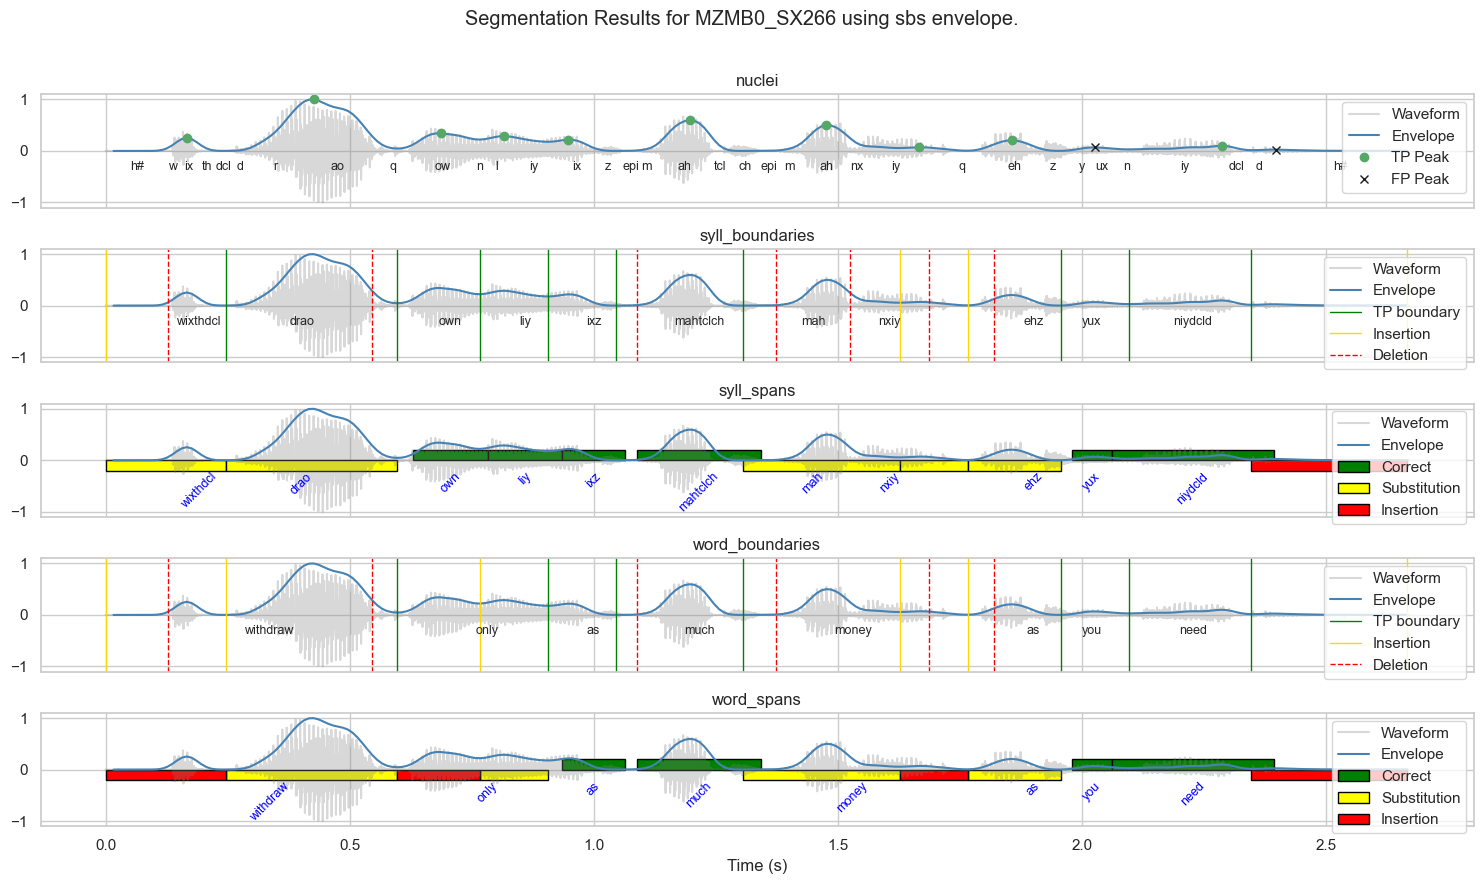

(<Figure size 1500x900 with 5 Axes>,
 <Axes: title={'center': 'word_spans'}, xlabel='Time (s)'>)

In [11]:
plot_segmentation_result(
    df=timit_sbs_results,
    file_id=timit_sample,
    envelope_fn = "sbs",
    envelope_kwargs=sbs_envelope_kwargs,
    phone_tier=TMT_PHONE_TIER,
    syll_tier=TMT_SYLL_TIER,
    word_tier=TMT_WORD_TIER
)


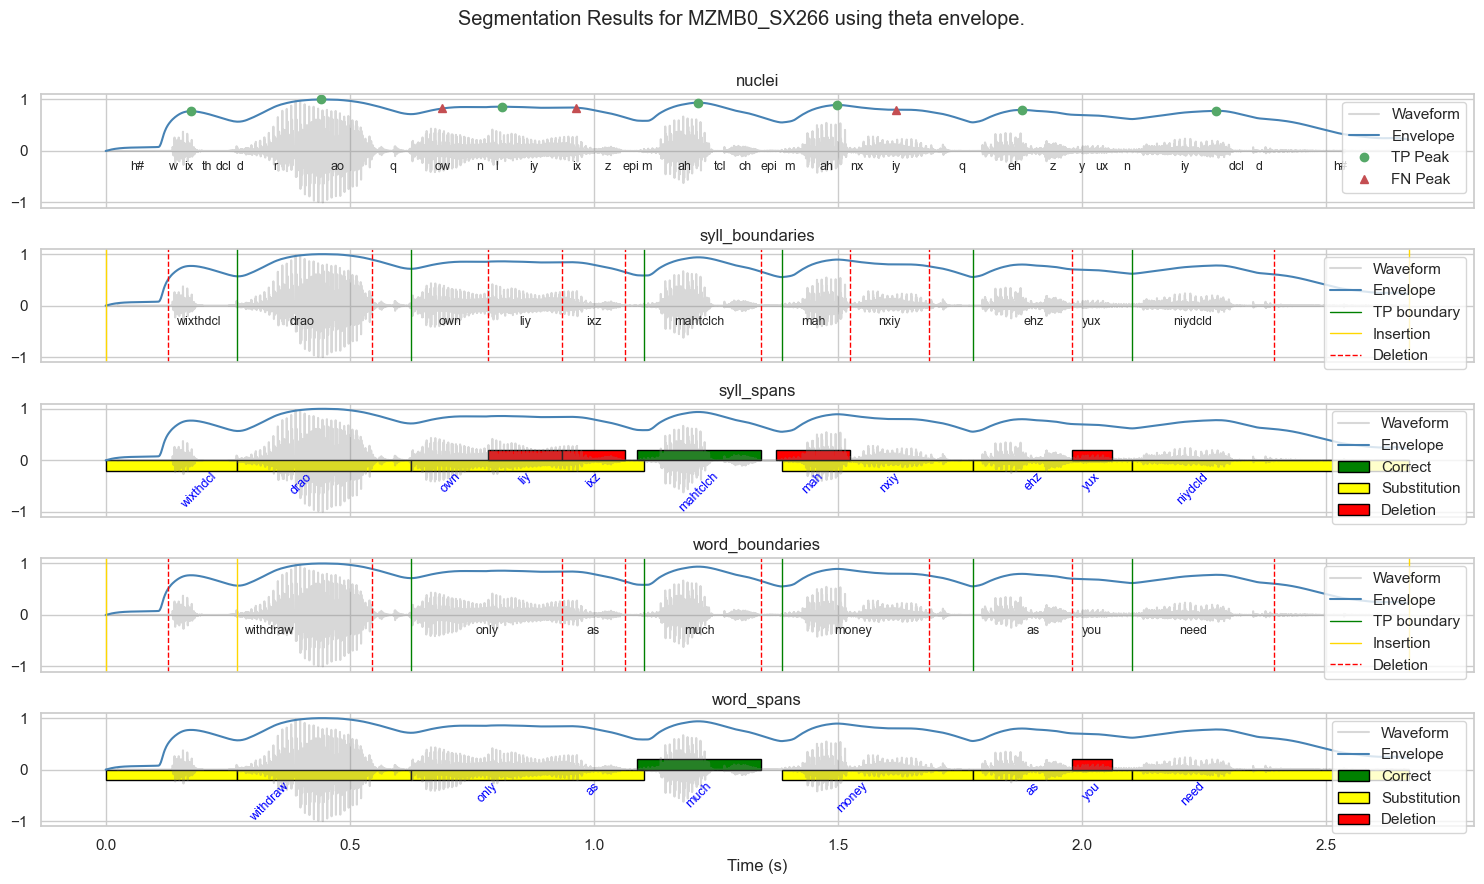

(<Figure size 1500x900 with 5 Axes>,
 <Axes: title={'center': 'word_spans'}, xlabel='Time (s)'>)

In [12]:
plot_segmentation_result(
    df=timit_theta_results,
    file_id=timit_sample,
    envelope_fn = "theta",
    envelope_kwargs=theta_envelope_kwargs,
    phone_tier=TMT_PHONE_TIER,
    syll_tier=TMT_SYLL_TIER,
    word_tier=TMT_WORD_TIER
)

In [ ]:
# Cleanup.
del timit_sbs_results
del timit_theta_results
del timit_sample

## Compare syllable segmentation on WikiSpanish

In [ ]:
wksp_sbs_results = pd.read_csv("./output/WikiSpanish_sbs_segmentation.csv")
wksp_theta_results = pd.read_csv("./output/WikiSpanish_theta_segmentation.csv")

In [ ]:
wksp_sample = wksp_sbs_results["file_id"].sample(1).values[0]

In [ ]:
plot_segmentation_result(
    df=wksp_sbs_results,
    file_id=wksp_sample,
    envelope_fn = "sbs",
    envelope_kwargs=sbs_envelope_kwargs,
    phone_tier=WKSP_PHONE_TIER,
    syll_tier=WKSP_SYLL_TIER,
    word_tier=WKSP_WORD_TIER
)

In [ ]:
plot_segmentation_result(
    df=wksp_sbs_results,
    file_id=wksp_sample,
    envelope_fn = "theta",
    envelope_kwargs=theta_envelope_kwargs,
    phone_tier=WKSP_PHONE_TIER,
    syll_tier=None,
    word_tier=WKSP_WORD_TIER
)

In [ ]:
# Cleanup.
del wksp_sbs_results
del wksp_theta_results
del wksp_sample

## Compare syllable segmentation on LibriSpeech

In [ ]:
lbsp_sbs_results = pd.read_csv("./output/LibriSpeech_sbs_segmentation.csv")
lbsp_theta_results = pd.read_csv("./output/LibriSpeech_theta_segmentation.csv")

In [ ]:
lbsp_sample = lbsp_sbs_results["file_id"].sample(1).values[0]

In [ ]:
plot_segmentation_result(
    df=lbsp_sbs_results,
    file_id=lbsp_sbs_results["file_id"].sample(1).values[0],
    envelope_fn = "sbs",
    envelope_kwargs=sbs_envelope_kwargs,
    phone_tier=LSP_PHONE_TIER,
    syll_tier=LSP_SYLL_TIER,
    word_tier=LSP_WORD_TIER
)

In [ ]:
plot_segmentation_result(
    df=lbsp_theta_results,
    file_id=lbsp_sbs_results["file_id"].sample(1).values[0],
    envelope_fn = "theta",
    envelope_kwargs=theta_envelope_kwargs,
    phone_tier=LSP_PHONE_TIER,
    syll_tier=LSP_SYLL_TIER,
    word_tier=LSP_WORD_TIER
)

In [ ]:
# Cleanup.
del lbsp_sbs_results
del lbsp_theta_results
del lbsp_sample

## Compare syllable segmentation on Ornat (Child-directed Spanish)

In [ ]:
ornat_sbs_results = pd.read_csv("./output/Ornat_sbs_segmentation.csv")
ornat_theta_results = pd.read_csv("./output/Ornat_theta_segmentation.csv")

In [ ]:
ornat_sample = ornat_sbs_results["file_id"].sample(1).values[0]

In [ ]:
plot_segmentation_result(
    df=ornat_sbs_results,
    file_id=ornat_sample,
    envelope_fn="sbs",
    envelope_kwargs=sbs_envelope_kwargs,
    phone_tier=ORNAT_PHONE_TIER,
    syll_tier=ORNAT_SYLL_TIER,
    word_tier=ORNAT_WORD_TIER
)

In [ ]:
plot_segmentation_result(
    df=ornat_theta_results,
    file_id=ornat_sample,
    envelope_fn="theta",
    envelope_kwargs=theta_envelope_kwargs,
    phone_tier=ORNAT_PHONE_TIER,
    syll_tier=ORNAT_SYLL_TIER,
    word_tier=ORNAT_WORD_TIER
)

In [ ]:
# Cleanup.
del ornat_sbs_results
del ornat_theta_results
del ornat_sample

## Compare syllable segmentation on PhiladelphiaHomeCorpus (Child-directed English)

In [ ]:
phc_sbs_results = pd.read_csv("./output/PhiladelphiaHomeCorpus_sbs_segmentation.csv")
phc_theta_results = pd.read_csv("./output/PhiladelphiaHomeCorpus_theta_segmentation.csv")

In [ ]:
phc_sample = phc_sbs_results["file_id"].sample(1).values[0]

In [ ]:
plot_segmentation_result(
    df=phc_sbs_results,
    file_id=phc_sample,
    envelope_fn="sbs",
    envelope_kwargs=sbs_envelope_kwargs,
    phone_tier=PHC_PHONE_TIER,
    syll_tier=PHC_SYLL_TIER,
    word_tier=PHC_WORD_TIER
)

In [ ]:
plot_segmentation_result(
    df=phc_theta_results,
    file_id=phc_sample,
    envelope_fn="theta",
    envelope_kwargs=theta_envelope_kwargs,
    phone_tier=PHC_PHONE_TIER,
    syll_tier=PHC_SYLL_TIER,
    word_tier=PHC_WORD_TIER
)

In [ ]:
# Cleanup.
del phc_sbs_results
del phc_theta_results
del phc_sample

## Compare syllable segmentation on Brent (Child-directed English)

In [ ]:
brent_sbs_results = pd.read_csv("./output/Brent_sbs_segmentation.csv")
brent_theta_results = pd.read_csv("./output/Brent_theta_segmentation.csv")

In [ ]:
brent_sample = brent_sbs_results["file_id"].sample(1).values[0]

In [ ]:
plot_segmentation_result(
    df=brent_sbs_results,
    file_id=brent_sample,
    envelope_fn="sbs",
    envelope_kwargs=sbs_envelope_kwargs,
    phone_tier=BRENT_PHONE_TIER,
    syll_tier=BRENT_SYLL_TIER,
    word_tier=BRENT_WORD_TIER
)

In [ ]:
plot_segmentation_result(
    df=brent_theta_results,
    file_id=brent_sample,
    envelope_fn="theta",
    envelope_kwargs=theta_envelope_kwargs,
    phone_tier=BRENT_PHONE_TIER,
    syll_tier=BRENT_SYLL_TIER,
    word_tier=BRENT_WORD_TIER
)

In [ ]:
# Cleanup.
del brent_sbs_results
del brent_theta_results
del brent_sample